# Traffic Sign Recognition with GoogLeNet (Inception v1)
**Ders:** Derin Öğrenme (FET312)  
**Takım:** DevTeam177  

**Proje Hakkında:**
Bu notebook, trafik levhalarını sınıflandırmak için **GoogLeNet** mimarisini kullanır. Model, **Full Fine-Tuning** (tüm katmanların eğitilmesi) yöntemiyle optimize edilmiştir. Inception modülleri sayesinde farklı ölçekteki öznitelikler aynı anda yakalanır.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import copy
from collections import Counter

# Cihaz ayarı (GPU varsa kullan, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

# Tekrarlanabilirlik için seed ayarı
torch.manual_seed(42)

Kullanılan Cihaz: cuda


## 1. Ayarlar ve Hiperparametreler
Eğitim süreci için gerekli olan dosya yolları ve temel parametreler (Batch Size, Learning Rate, Epoch) burada tanımlanır.
* **Learning Rate (0.0001):** Modelin tüm katmanlarını eğittiğimiz (Full Fine-Tuning) için, ağırlıkların hassas bir şekilde güncellenmesi adına düşük bir öğrenme oranı seçilmiştir.

In [2]:
DATA_DIR = r"C:\Users\aktem\OneDrive\Masaüstü\Derin_Öğrenme\GTSRB\Final_Training\Images"

# Hiperparametreler
BATCH_SIZE = 32
LEARNING_RATE = 0.0001 # Full Fine-Tuning için düşük tutuyoruz
NUM_EPOCHS = 10

# Veri Dönüşümleri (Data Augmentation)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),       
        transforms.RandomRotation(15),       
        transforms.RandomHorizontalFlip(),   
        transforms.ToTensor(),               
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
print("Ayarlar ve dönüşüm kuralları hazır.")

Ayarlar ve dönüşüm kuralları hazır.


## 2. Özelleştirilmiş Dataset Sınıfı
`Subset` ile ayrılan verilerin üzerine dönüşüm (transform) kurallarını uygulayabilmek için özel bir sınıf yazıyoruz. Bu sınıf, her resim çağrıldığında onu otomatik olarak Tensor'a çevirir.

In [3]:
# Özelleştirilmiş Dataset Sınıfı
class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)
        
print("CustomDataset sınıfı tanımlandı.")

CustomDataset sınıfı tanımlandı.


## 3. Veri Seti Yükleme ve Sızıntı Korumalı Ayrıştırma
GTSRB veri setinde, aynı videodan alınan ardışık kareler (Tracks) bulunur. Eğer rastgele ayrıştırma yapılırsa, aynı levhanın benzer kareleri hem eğitim hem test setine düşerek "Veri Sızıntısına" (Data Leakage) neden olur.
Bunu engellemek için **GroupShuffleSplit** kullanılarak ayrıştırma resim bazlı değil, klasör (Track ID) bazlı yapılır.

In [4]:
# Veriyi Tarama
if not os.path.exists(DATA_DIR):
    print(f"HATA: Klasör bulunamadı -> {DATA_DIR}")
else:
    full_dataset = datasets.ImageFolder(DATA_DIR) 
    class_names = full_dataset.classes
    num_classes = len(class_names)

    # Track ID Gruplama (Sızıntı Önleyici)
    groups = []
    for path, label in full_dataset.imgs:
        file_name = os.path.basename(path)
        track_id = file_name.split('_')[0] 
        groups.append(f"class{label}_{track_id}")

    # Gruplara Göre Ayırma (Split)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(gss.split(X=np.zeros(len(full_dataset)), y=full_dataset.targets, groups=groups))

    # Subsetleri Oluştur ve Transformları Ata
    train_dataset = CustomDataset(Subset(full_dataset, train_idx), transform=data_transforms['train'])
    val_dataset = CustomDataset(Subset(full_dataset, val_idx), transform=data_transforms['val'])

    print(f"Veri Hazır: {len(train_dataset)} Eğitim | {len(val_dataset)} Doğrulama")

Veri Hazır: 31349 Eğitim | 7860 Doğrulama


## 4. DataLoader Oluşturma
Veriyi modele beslemek için DataLoader'lar oluşturulur.
* **Not:** Windows işletim sisteminde `multiprocessing` hatası almamak için `num_workers=0` olarak ayarlanmıştır.

In [5]:
# DataLoader
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
}
print("DataLoader'lar oluşturuldu.")

DataLoader'lar oluşturuldu.


## 5. Veri Analizi (Sınıf Dağılımı)
Veri setindeki sınıf dengesizliğini görselleştirmek için her sınıftan kaç adet örnek olduğunu gösteren bir grafik çizdirilir.

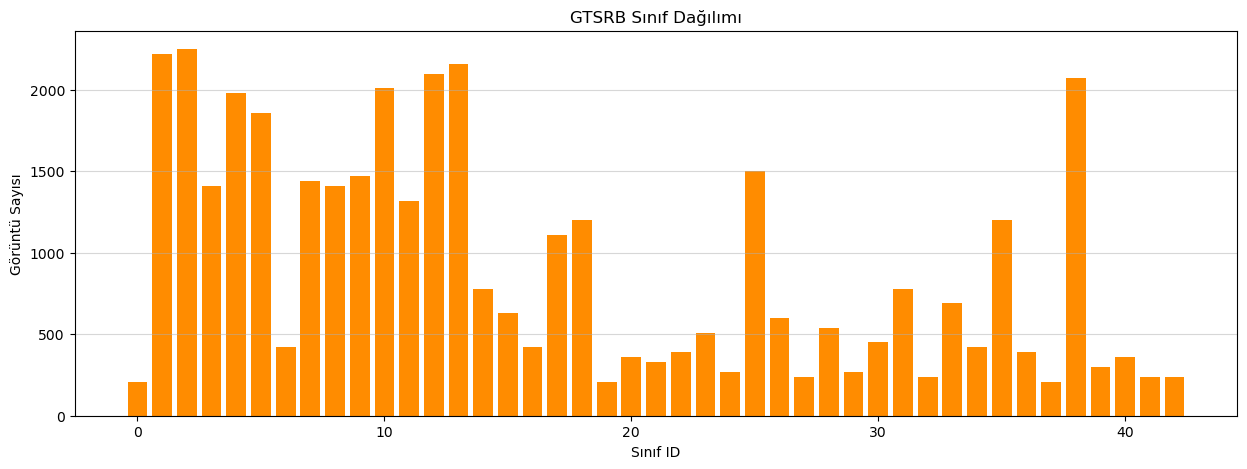

In [6]:
# Etiketleri say
labels = full_dataset.targets
label_counts = Counter(labels)
sorted_counts = dict(sorted(label_counts.items()))

# Grafiği çiz
plt.figure(figsize=(15, 5))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='darkorange')
plt.xlabel('Sınıf ID')
plt.ylabel('Görüntü Sayısı')
plt.title('GTSRB Sınıf Dağılımı')
plt.grid(axis='y', alpha=0.5)
plt.show()

## 6. Model Tanımlama (GoogLeNet)
GoogLeNet (Inception v1) modeli yüklenir ve son katmanları 43 sınıflı veri setimize göre uyarlanır.
* **Auxiliary Logits:** GoogLeNet eğitim sırasında kaybolan gradyan problemini çözmek için 2 adet yardımcı çıkış (Aux1, Aux2) kullanır. Bunların da sınıf sayımıza göre güncellenmesi gerekir.

In [7]:
def get_googlenet_model(num_classes):
    print("GoogLeNet Modeli İndiriliyor...")
    try:
        model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
    except:
        model = models.googlenet(pretrained=True)
    
    # Full Fine-Tuning
    
    # Ana Çıkış Katmanını Değiştir
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # Yardımcı Çıkışları (Auxiliary Logits) Değiştir
    if hasattr(model, 'aux1') and model.aux1 is not None:
        model.aux1.fc2 = nn.Linear(1024, num_classes)
    if hasattr(model, 'aux2') and model.aux2 is not None:
        model.aux2.fc2 = nn.Linear(1024, num_classes)

    return model

# Modeli Başlat
model = get_googlenet_model(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Model ve Optimizer hazır.")

GoogLeNet Modeli İndiriliyor...
Model ve Optimizer hazır.


## 7. Eğitim Döngüsü
Model belirlenen Epoch sayısı kadar eğitilir.
* **Eğitim Modu (Train):** Model 3 çıktı verir (Ana çıktı + 2 Yardımcı). Loss, bu üçünün ağırlıklı toplamından hesaplanır.
* **Doğrulama Modu (Eval):** Model sadece ana çıktıyı verir.
* Her epoch sonunda en iyi doğrulama başarısına (Validation Accuracy) sahip model kaydedilir.

In [8]:
# Tarihçeleri tutmak için listeler
train_loss_history = []
val_acc_history = []

print(f"Eğitim Başlıyor ({NUM_EPOCHS} Epoch)...")
print("-" * 60)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(NUM_EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # GoogLeNet'in özel çıktısı (Auxiliary Logits)
        outputs = model(inputs)
        
        if isinstance(outputs, torch.Tensor):
            loss = criterion(outputs, labels)
        else:
            # Eğitim modunda tuple döner: (logits, aux1, aux2)
            loss0 = criterion(outputs.logits, labels)
            loss1 = criterion(outputs.aux_logits1, labels)
            loss2 = criterion(outputs.aux_logits2, labels)
            loss = loss0 + 0.3 * loss1 + 0.3 * loss2
            
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_loss_history.append(epoch_loss)
    
    # --- Validation ---
    model.eval()
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
    epoch_acc = running_corrects.double() / len(val_dataset)
    # Tensor'u sayıya çevirip listeye ekle
    val_acc_history.append(epoch_acc.item() if hasattr(epoch_acc, 'item') else epoch_acc)
    
    # En iyi modeli kaydet
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.4f}")

print("-" * 60)
print(f"Eğitim Tamamlandı. En Yüksek Başarı: {best_acc:.4f}")
model.load_state_dict(best_model_wts)

Eğitim Başlıyor (10 Epoch)...
------------------------------------------------------------
Epoch 1/10 -> Train Loss: 0.5903 | Val Acc: 0.9551
Epoch 2/10 -> Train Loss: 0.0429 | Val Acc: 0.9539
Epoch 3/10 -> Train Loss: 0.0238 | Val Acc: 0.9632
Epoch 4/10 -> Train Loss: 0.0157 | Val Acc: 0.9564
Epoch 5/10 -> Train Loss: 0.0111 | Val Acc: 0.9593
Epoch 6/10 -> Train Loss: 0.0117 | Val Acc: 0.9570
Epoch 7/10 -> Train Loss: 0.0078 | Val Acc: 0.9603
Epoch 8/10 -> Train Loss: 0.0077 | Val Acc: 0.9611
Epoch 9/10 -> Train Loss: 0.0057 | Val Acc: 0.9620
Epoch 10/10 -> Train Loss: 0.0084 | Val Acc: 0.9551
------------------------------------------------------------
Eğitim Tamamlandı. En Yüksek Başarı: 0.9632


<All keys matched successfully>

## 8. Sonuçların Görselleştirilmesi
Eğitim Kaybı (Train Loss) ve Doğrulama Başarısı (Validation Accuracy) grafik üzerinde çizdirilerek modelin öğrenme süreci analiz edilir.

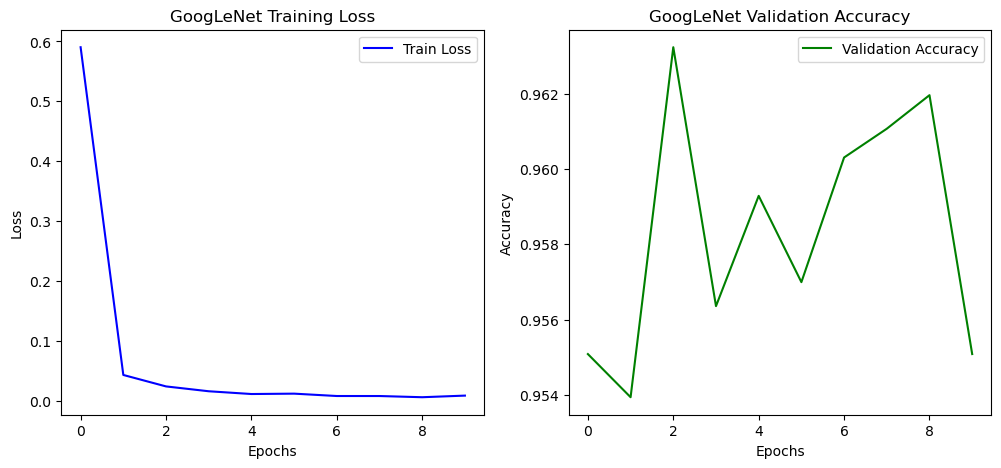

In [9]:
# Loss ve Accuracy Grafikleri
plt.figure(figsize=(12, 5))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.title('GoogLeNet Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(val_acc_history, label='Validation Accuracy', color='green')
plt.title('GoogLeNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 9. Raporlama ve Kaydetme
Modelin sınıf bazlı performansı (Precision, Recall, F1-Score) `classification_report` ile hesaplanır ve sonuçlar CSV dosyasına kaydedilir. Ayrıca eğitilen modelin ağırlıkları `.pth` dosyası olarak saklanır.

In [10]:
import pandas as pd
from sklearn.metrics import classification_report


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def get_classification_report(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            # GoogLeNet eval modunda tek çıktı verir
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Tüm sınıflar için rapor
    report = classification_report(
        y_true, y_pred, 
        target_names=class_names, 
        labels=range(num_classes),
        output_dict=True, 
        zero_division=0
    )
    
    # Raporu DataFrame'e çevir
    df = pd.DataFrame(report).transpose()
    
    # 'support' sütununu tam sayıya çevir
    if 'support' in df.columns:
        df['support'] = df['support'].astype(int)
        
    return df

print("Final Rapor Hazırlanıyor (Tüm Sınıflar)...")
# Fonksiyonu çağır
df_report = get_classification_report(model, dataloaders['val'])

# --- TÜM TABLOYU GÖSTER ---
print("\n" + "="*50)
print(f"GoogLeNet Modeli - Detaylı Sınıflandırma Raporu")
print("="*50)

# Tabloyu ekrana bas
try:
    display(df_report)
except:
    print(df_report)

# Dosyaları Kaydet
csv_name = 'DevTeam177_GoogLeNet_FullFineTuned_AllClasses.csv'
model_name = 'googlenet_full_finetuned.pth'

df_report.to_csv(csv_name)
torch.save(model.state_dict(), model_name)

print(f"\nİşlem Başarıyla Tamamlandı.")
print(f"CSV Raporu Kaydedildi: {csv_name}")
print(f"Model Kaydedildi: {model_name}")

Final Rapor Hazırlanıyor (Tüm Sınıflar)...

GoogLeNet Modeli - Detaylı Sınıflandırma Raporu


,precision,recall,f1-score,support
00000,0.000000,0.000000,0.000000,0
00001,0.988920,0.991667,0.990291,360
00002,0.995261,1.000000,0.997625,420
00003,0.995851,1.000000,0.997921,240
00004,0.991701,0.995833,0.993763,480
00005,0.989967,0.986667,0.988314,300
00006,1.000000,1.000000,1.000000,120
00007,0.988930,0.992593,0.990758,270
00008,0.980488,0.957143,0.968675,210
00009,0.990066,0.996667,0.993355,300



İşlem Başarıyla Tamamlandı.
CSV Raporu Kaydedildi: DevTeam177_GoogLeNet_FullFineTuned_AllClasses.csv
Model Kaydedildi: googlenet_full_finetuned.pth


## 10. Karmaşıklık Matrisi (Confusion Matrix)
Modelin hangi sınıfları birbiriyle karıştırdığını daha detaylı analiz etmek için **Karmaşıklık Matrisi** oluşturulur.
* **X Ekseni (Yatay):** Modelin Tahmin Ettiği Sınıflar.
* **Y Ekseni (Dikey):** Gerçek (Doğru) Sınıflar.
* **Yorumlama:** Matrisin sol üstünden sağ altına giden köşegen üzerindeki yoğunluklar **doğru tahminleri** gösterir. Köşegen dışında kalan ve renklenen kutucuklar ise modelin **hata yaptığı** (karıştırdığı) levhaları işaret eder.

Confusion Matrix Çiziliyor...


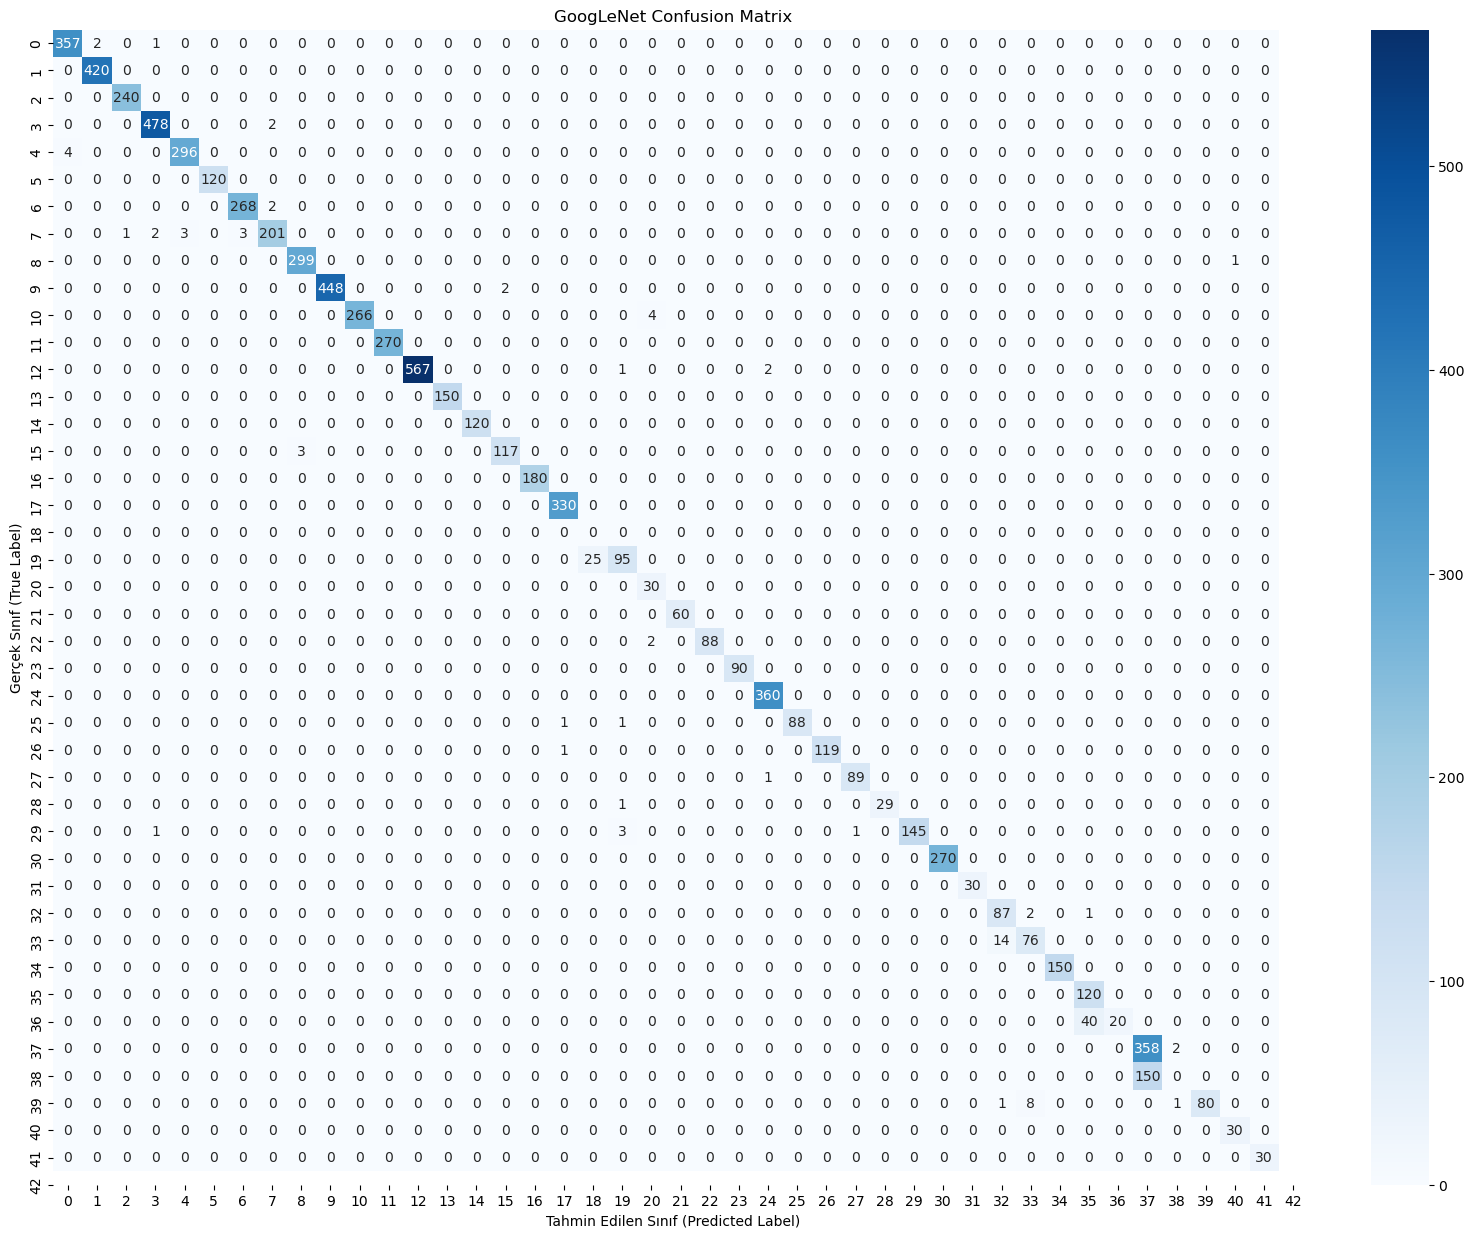

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    # Verileri topla
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Matrisi hesapla
    cm = confusion_matrix(y_true, y_pred)
    
    # Grafiği çiz
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(num_classes), 
                yticklabels=range(num_classes))
    
    plt.title('GoogLeNet Confusion Matrix')
    plt.ylabel('Gerçek Sınıf (True Label)')
    plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')
    plt.show()

print("Confusion Matrix Çiziliyor...")
plot_confusion_matrix(model, dataloaders['val'])